# Graph Learning

## Lab 7: Graph Neural Networks

In this lab, you will learn to classify nodes using a graph neural network (GNN).

## Import

In [131]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [132]:
from sknetwork.classification import get_accuracy_score
from sknetwork.data import load_netset
from sknetwork.embedding import Spectral
from sknetwork.gnn import GNNClassifier
from sknetwork.utils import directed2undirected
from sklearn import metrics

from sklearn.manifold import TSNE

## Data

We will work on the following datasets (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Cora (directed graph + bipartite graph)
* WikiVitals (directed graph + bipartite graph)

Both datasets are graphs with node features (given by the bipartite graph) and ground-truth labels.

In [133]:
cora = load_netset('cora')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


In [134]:
def visualize_embedding(embedding, labels, size=(6,6)):
    """Visualize embedding in 2 dimensions using TSNE. """
    print("Computing TSNE...")
    tsne = TSNE(random_state=8).fit_transform(embedding)
    fig, ax = plt.subplots(1, 1, figsize=size)
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, s=50, cmap='hsv')
    plt.xticks([])
    plt.yticks([])
    plt.show()

## 1. Cora

We start with the Cora dataset. We check the embedding of the nodes before and after learning, and the impact of the GNN architecture on accuracy.

In [135]:
dataset = cora

In [136]:
adjacency = dataset.adjacency
features = dataset.biadjacency
labels_true = dataset.labels

In [137]:
# we use undirected graphs
adjacency = directed2undirected(adjacency)

## To do

Consider a GNN with a single hidden layer of dimension 16.

* Run a single forward pass on the data, without learning.
* Display the embedding provided by the hidden layer.

In [138]:
hidden_dim = 16

In [139]:
n_labels = len(set(labels_true))

In [140]:
gnn = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)

In [141]:
gnn

GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [142]:
output = gnn.forward(adjacency, features)

In [143]:
embedding = gnn.layers[0].embedding

Computing TSNE...


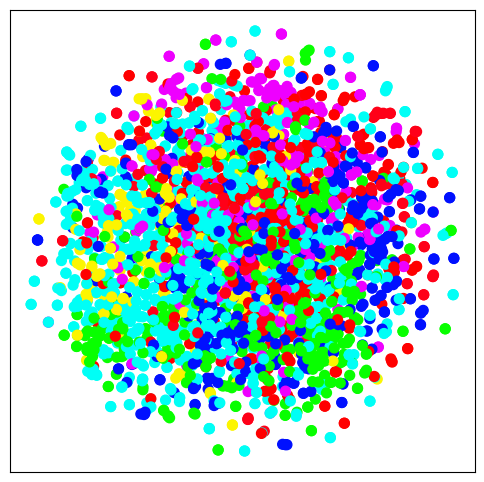

In [144]:
visualize_embedding(embedding, labels_true)

## To do

We now train the GNN.

* Train the GNN with 50% / 50% train / test split.
* Give the accuracy of the classification on the train and test sets. 
* Give the total number of parameters.
* Display the embedding provided by the hidden layer.

In [145]:
# train / test split
train_ratio = 0.5
labels = labels_true.copy()
train_mask = np.random.random(size=len(labels)) < train_ratio
test_mask = ~train_mask
labels[test_mask] = -1

In [146]:
gnn.fit(adjacency, features, labels)

In epoch   0, loss: 1.977, train accuracy: 0.162
In epoch  10, loss: 1.652, train accuracy: 0.557
In epoch  20, loss: 1.445, train accuracy: 0.844
In epoch  30, loss: 1.333, train accuracy: 0.907
In epoch  40, loss: 1.270, train accuracy: 0.941
In epoch  50, loss: 1.235, train accuracy: 0.962
In epoch  60, loss: 1.215, train accuracy: 0.975
In epoch  70, loss: 1.202, train accuracy: 0.982
In epoch  80, loss: 1.193, train accuracy: 0.988
In epoch  90, loss: 1.187, train accuracy: 0.991


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [147]:
labels_pred = gnn.predict()

In [148]:
# accuracy on train and test sets
train_acc = get_accuracy_score(labels_true[train_mask], labels_pred[train_mask]) 
test_acc = get_accuracy_score(labels_true[test_mask], labels_pred[test_mask])
print(f'Train accuracy: {train_acc:.3f}')
print(f'Test accuracy: {test_acc:.3f}')

Train accuracy: 0.993
Test accuracy: 0.807


In [149]:
# parameters
input_dim = features.shape[1]  # input features dim

# first layer (input_dim x hidden_dim) + bias (same as hidden_dim)
n_params_1 = input_dim * hidden_dim + hidden_dim

# second layer (hidden_dim x n_labels) + bias (same as n_labels)
n_params_2 = hidden_dim * n_labels + n_labels

# total
n_params = n_params_1 + n_params_2
print(f'Number of parameters: {n_params}')


Number of parameters: 23063


Computing TSNE...


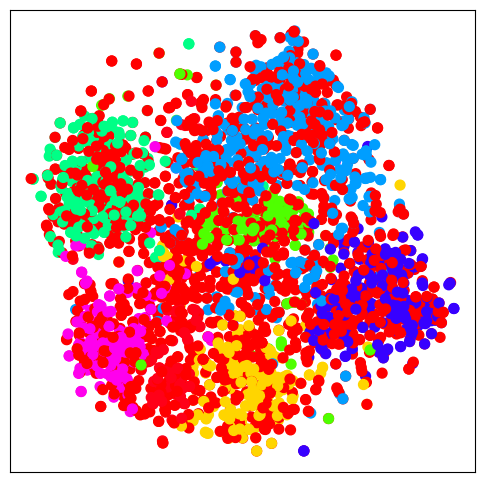

In [150]:
# display embedding from hidden layer
embedding = gnn.layers[0].embedding
visualize_embedding(embedding, labels)

## To do

* Retrain the GNN with an empty graph.
* Compare the accuracy of the classification with that of the previous model. 
* Comment the results. <br>What is the learning model?

In [151]:
empty = sparse.csr_matrix(adjacency.shape)

In [152]:
# retrain on empty 
gnn.fit(empty, features, labels)

In epoch   0, loss: 1.390, train accuracy: 0.848
In epoch  10, loss: 1.250, train accuracy: 0.973
In epoch  20, loss: 1.203, train accuracy: 0.991
In epoch  30, loss: 1.188, train accuracy: 0.993
In epoch  40, loss: 1.181, train accuracy: 0.996
In epoch  50, loss: 1.178, train accuracy: 0.997
In epoch  60, loss: 1.176, train accuracy: 0.997
In epoch  70, loss: 1.174, train accuracy: 0.997
In epoch  80, loss: 1.173, train accuracy: 0.998
In epoch  90, loss: 1.172, train accuracy: 0.998


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [153]:
labels_pred = gnn.predict()

In [154]:
train_acc_empty = get_accuracy_score(labels_true[train_mask], labels_pred[train_mask])
test_acc_empty = get_accuracy_score(labels_true[test_mask], labels_pred[test_mask])

print(f'Train accuracy')
print(f'On empty: {train_acc_empty:.3f} \t On full: {train_acc:.3f}')

print(f'Test accuracy')
print(f'On empty: {test_acc_empty:.3f} \t On full: {test_acc:.3f}')

Train accuracy
On empty: 0.998 	 On full: 0.993
Test accuracy
On empty: 0.641 	 On full: 0.807


**Answer**: The model is overfitting the trainning set, as we can see its accuracy get closer to 1 during training.

## To do

We now consider a hidden layer of dimension 32.

* Retrain the GNN (with the graph).
* Give the accuracy of the classification and the number of parameters.
* Comment the results.

In [155]:
# changing dimension
hidden_dim_32 = 32
gnn_32 = GNNClassifier(dims=[hidden_dim_32, n_labels], verbose=True)
gnn_32

GNNClassifier(
    Convolution(layer_type: conv, out_channels: 32, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

Computing TSNE...


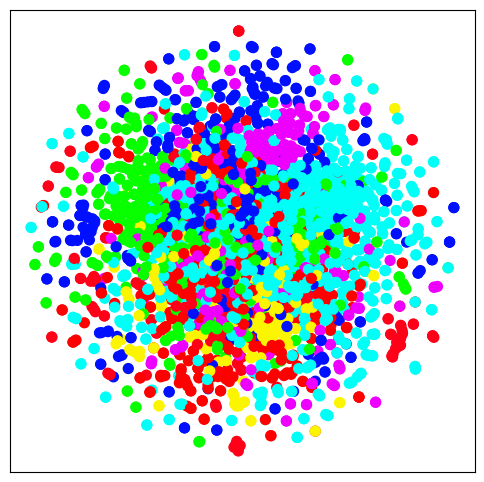

In [156]:
output_32 = gnn_32.forward(adjacency, features)
embedding_32 = gnn_32.layers[0].embedding
visualize_embedding(embedding_32, labels_true)

In [157]:
# training
gnn_32.fit(adjacency, features, labels)

In epoch   0, loss: 1.964, train accuracy: 0.178
In epoch  10, loss: 1.352, train accuracy: 0.871
In epoch  20, loss: 1.230, train accuracy: 0.969
In epoch  30, loss: 1.194, train accuracy: 0.987
In epoch  40, loss: 1.182, train accuracy: 0.994
In epoch  50, loss: 1.176, train accuracy: 0.996
In epoch  60, loss: 1.173, train accuracy: 0.998
In epoch  70, loss: 1.171, train accuracy: 0.998
In epoch  80, loss: 1.170, train accuracy: 0.998
In epoch  90, loss: 1.169, train accuracy: 0.999


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 32, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [158]:
labels_pred_32 = gnn_32.predict()

In [159]:
train_acc_32 = get_accuracy_score(labels_true[train_mask], labels_pred_32[train_mask]) 
test_acc_32 = get_accuracy_score(labels_true[test_mask], labels_pred_32[test_mask])
# print(f'Train accuracy: {train_acc_32:.3f}')
# print(f'Test accuracy: {test_acc_32:.3f}')

print(f'Train accuracy')
print(f'16: {train_acc:.3f} \t32: {train_acc_32:.3f}')

print(f'Test accuracy')
print(f'16: {test_acc:.3f} \t32: {test_acc_32:.3f}')

Train accuracy
16: 0.993 	32: 0.999
Test accuracy
16: 0.807 	32: 0.819


In [160]:
# parameters
n_params_32 = hidden_dim_32 * (features.shape[1] + 1) + n_labels * (hidden_dim_32 + 1)
print(f'Number of parameters: {n_params_32}')

Number of parameters: 46119


**Answer**: We can see that increasing the hidden dimension from 16 to 32 slightly improves the accuracy on both train and test sets. However, The number of parameters also increases.

## To do

Finally , we take 2 hidden layers, each of dimension 16.

* Retrain the GNN.
* Give the accuracy of the classification and the number of parameters.
* Comment the results.

In [161]:
# 2 hidden layers of dim 16
gnn_2 = GNNClassifier(dims=[hidden_dim, hidden_dim, n_labels], verbose=True)
gnn_2


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

Computing TSNE...


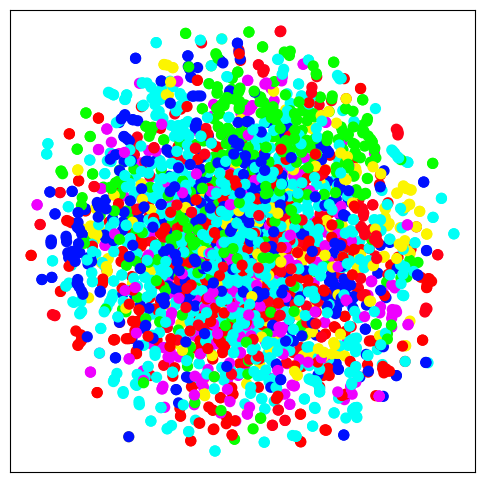

In [162]:
output_2 = gnn_2.forward(adjacency, features)
embedding_2 = gnn_2.layers[0].embedding
visualize_embedding(embedding_2, labels_true)

In [163]:
# training
gnn_2.fit(adjacency, features, labels)

In epoch   0, loss: 2.018, train accuracy: 0.113
In epoch  10, loss: 1.741, train accuracy: 0.486
In epoch  20, loss: 1.542, train accuracy: 0.789
In epoch  30, loss: 1.357, train accuracy: 0.879
In epoch  40, loss: 1.278, train accuracy: 0.924
In epoch  50, loss: 1.240, train accuracy: 0.950
In epoch  60, loss: 1.222, train accuracy: 0.959
In epoch  70, loss: 1.211, train accuracy: 0.969
In epoch  80, loss: 1.201, train accuracy: 0.977
In epoch  90, loss: 1.193, train accuracy: 0.983


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [164]:
labels_pred_2 = gnn_2.predict()

In [165]:
train_acc_2 = get_accuracy_score(labels_true[train_mask], labels_pred_2[train_mask])
test_acc_2 = get_accuracy_score(labels_true[test_mask], labels_pred_2[test_mask])

print(f'Train accuracy')
print(f'16: {train_acc_2:.3f} \t16(single layer):{train_acc:.3f} \t32: {train_acc_32:.3f}')

print(f'Test accuracy')
print(f'16: {test_acc_2:.3f} \t16(single layer):{test_acc:.3f} \t32: {test_acc_32:.3f}')

Train accuracy
16: 0.986 	16(single layer):0.993 	32: 0.999
Test accuracy
16: 0.800 	16(single layer):0.807 	32: 0.819


In [166]:
# parameters
# since both layers have the same dimension, we have:
n_params_2 = hidden_dim * (features.shape[1] + 1) + hidden_dim * (hidden_dim + 1) + n_labels * (hidden_dim + 1)
print(f'Number of parameters: {n_params_2}')

Number of parameters: 23335


**Answer**: This version needs less parameters than the `hidden_dim = 32` version, but just a few more than the single layer `hidden_dim = 16` model. Regarding the accuracy, it does not improve the performance of the `hidden_dim = 32` version.

## 2. Wikivitals

We now focus on Wikivitals. We take the spectral embedding of the article-word bipartite graph as features.

In [167]:
dataset_WV = wikivitals

In [168]:
adjacency_WV = dataset_WV.adjacency
biadjacency_WV = dataset_WV.biadjacency
names_WV = dataset_WV.names
labels_true_WV = dataset_WV.labels
names_labels_WV = dataset_WV.names_labels

In [169]:
# we consider the graph as undirected
adjacency_WV = directed2undirected(adjacency_WV)

In [170]:
# we use the spectral embedding of the bipartite graph as features
spectral = Spectral(20)
features_WV = spectral.fit_transform(biadjacency_WV)

## To do

We consider a GNN with a single hidden layer of dimension 16.
* Train the GNN with 50% / 50% train / test split.
* Give the accuracy of the classification.
* Display the confusion matrix of the test set.
* Give for each label the 5 articles of the test set classified with the highest confidence.

In [171]:
n_labels_WV = len(set(labels_true_WV))

In [172]:
print(set(labels_true_WV))
print(np.unique(labels_true_WV))

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)}
[ 0  1  2  3  4  5  6  7  8  9 10]


In [173]:
gnn_WV = GNNClassifier(dims=[hidden_dim, n_labels_WV], verbose=True)

In [174]:
# train / test split
train_ratio = 0.5
labels_WV = labels_true_WV.copy()
train_mask = np.random.random(size=len(labels_WV)) < train_ratio
test_mask = ~train_mask
labels_WV[test_mask] = -1

In [175]:
gnn_WV.fit(adjacency_WV, features_WV, labels_WV)

In epoch   0, loss: 2.406, train accuracy: 0.075
In epoch  10, loss: 2.311, train accuracy: 0.345
In epoch  20, loss: 2.167, train accuracy: 0.611
In epoch  30, loss: 2.029, train accuracy: 0.724
In epoch  40, loss: 1.921, train accuracy: 0.767
In epoch  50, loss: 1.853, train accuracy: 0.791
In epoch  60, loss: 1.820, train accuracy: 0.807
In epoch  70, loss: 1.800, train accuracy: 0.817
In epoch  80, loss: 1.788, train accuracy: 0.823
In epoch  90, loss: 1.781, train accuracy: 0.829


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 11, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [176]:
labels_pred_WV = gnn_WV.predict()

train_acc_WV = get_accuracy_score(labels_true_WV[train_mask], labels_pred_WV[train_mask])
test_acc_WV = get_accuracy_score(labels_true_WV[test_mask], labels_pred_WV[test_mask])

print(f'WikiVitals train accuracy: {train_acc_WV:.4f}')
print(f'WikiVitals test accuracy: {test_acc_WV:.4f}')

WikiVitals train accuracy: 0.8362
WikiVitals test accuracy: 0.8267


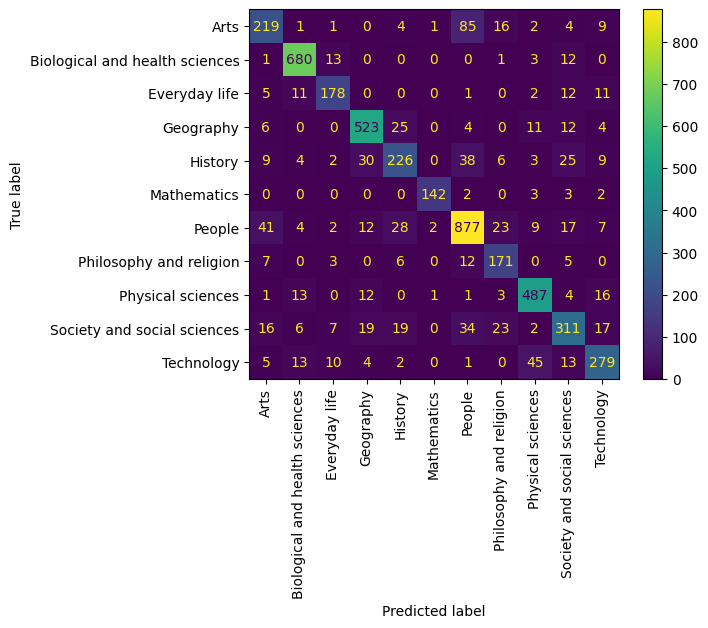

In [177]:
valid_labels = np.arange(len(names_labels_WV)) 

confusion_matrix = metrics.confusion_matrix(labels_true_WV[test_mask], labels_pred_WV[test_mask], labels=valid_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=names_labels_WV)

cm_display.plot()
plt.xticks(rotation=90, ha='center')
plt.show()

In [178]:

probs = gnn_WV.predict_proba()

for i, name in enumerate(names_labels_WV):

    predicted = (labels_pred_WV[test_mask] == i)
    if predicted.sum() > 0:
 
        confidences = probs[test_mask][predicted, i]

        article_indices = np.where(test_mask)[0][predicted]

        top5_idx = np.argsort(confidences)[-5:][::-1]
        print(f"\nLabel {name} - Top 5 articles:")
        for i, idx in enumerate(top5_idx):
            if i < len(article_indices):
                article_name = names_WV[article_indices[idx]]
                confidence = confidences[idx]
                print(f"  {article_name}: {confidence:.3f}")


Label Arts - Top 5 articles:
  Land art: 0.993
  Visual arts: 0.992
  Music: 0.992
  Art Nouveau: 0.991
  Performance art: 0.988

Label Biological and health sciences - Top 5 articles:
  Flowering plant: 1.000
  Insect: 1.000
  Carl Linnaeus: 1.000
  Skull: 1.000
  Vertebral column: 1.000

Label Everyday life - Top 5 articles:
  Cue sports: 0.999
  Cycle sport: 0.999
  Karate: 0.999
  Bowling: 0.998
  Freestyle wrestling: 0.998

Label Geography - Top 5 articles:
  Köppen climate classification: 1.000
  Indian Ocean: 1.000
  Pacific Ocean: 1.000
  Timor Sea: 1.000
  Arabian Sea: 1.000

Label History - Top 5 articles:
  Byzantine Empire: 0.987
  Achaemenid Empire: 0.976
  Migration Period: 0.972
  Republic of Venice: 0.968
  Parthian Empire: 0.967

Label Mathematics - Top 5 articles:
  Function (mathematics): 1.000
  Real number: 1.000
  Continuous function: 1.000
  Field (mathematics): 1.000
  Algebraic geometry: 1.000

Label People - Top 5 articles:
  Rosa Parks: 1.000
  Ralph Waldo E

## To do

Compare the results with those obtained with:
* Heat diffusion on the graph.
* Logistic regression on the features.